<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB

Eksik değerler:
 age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


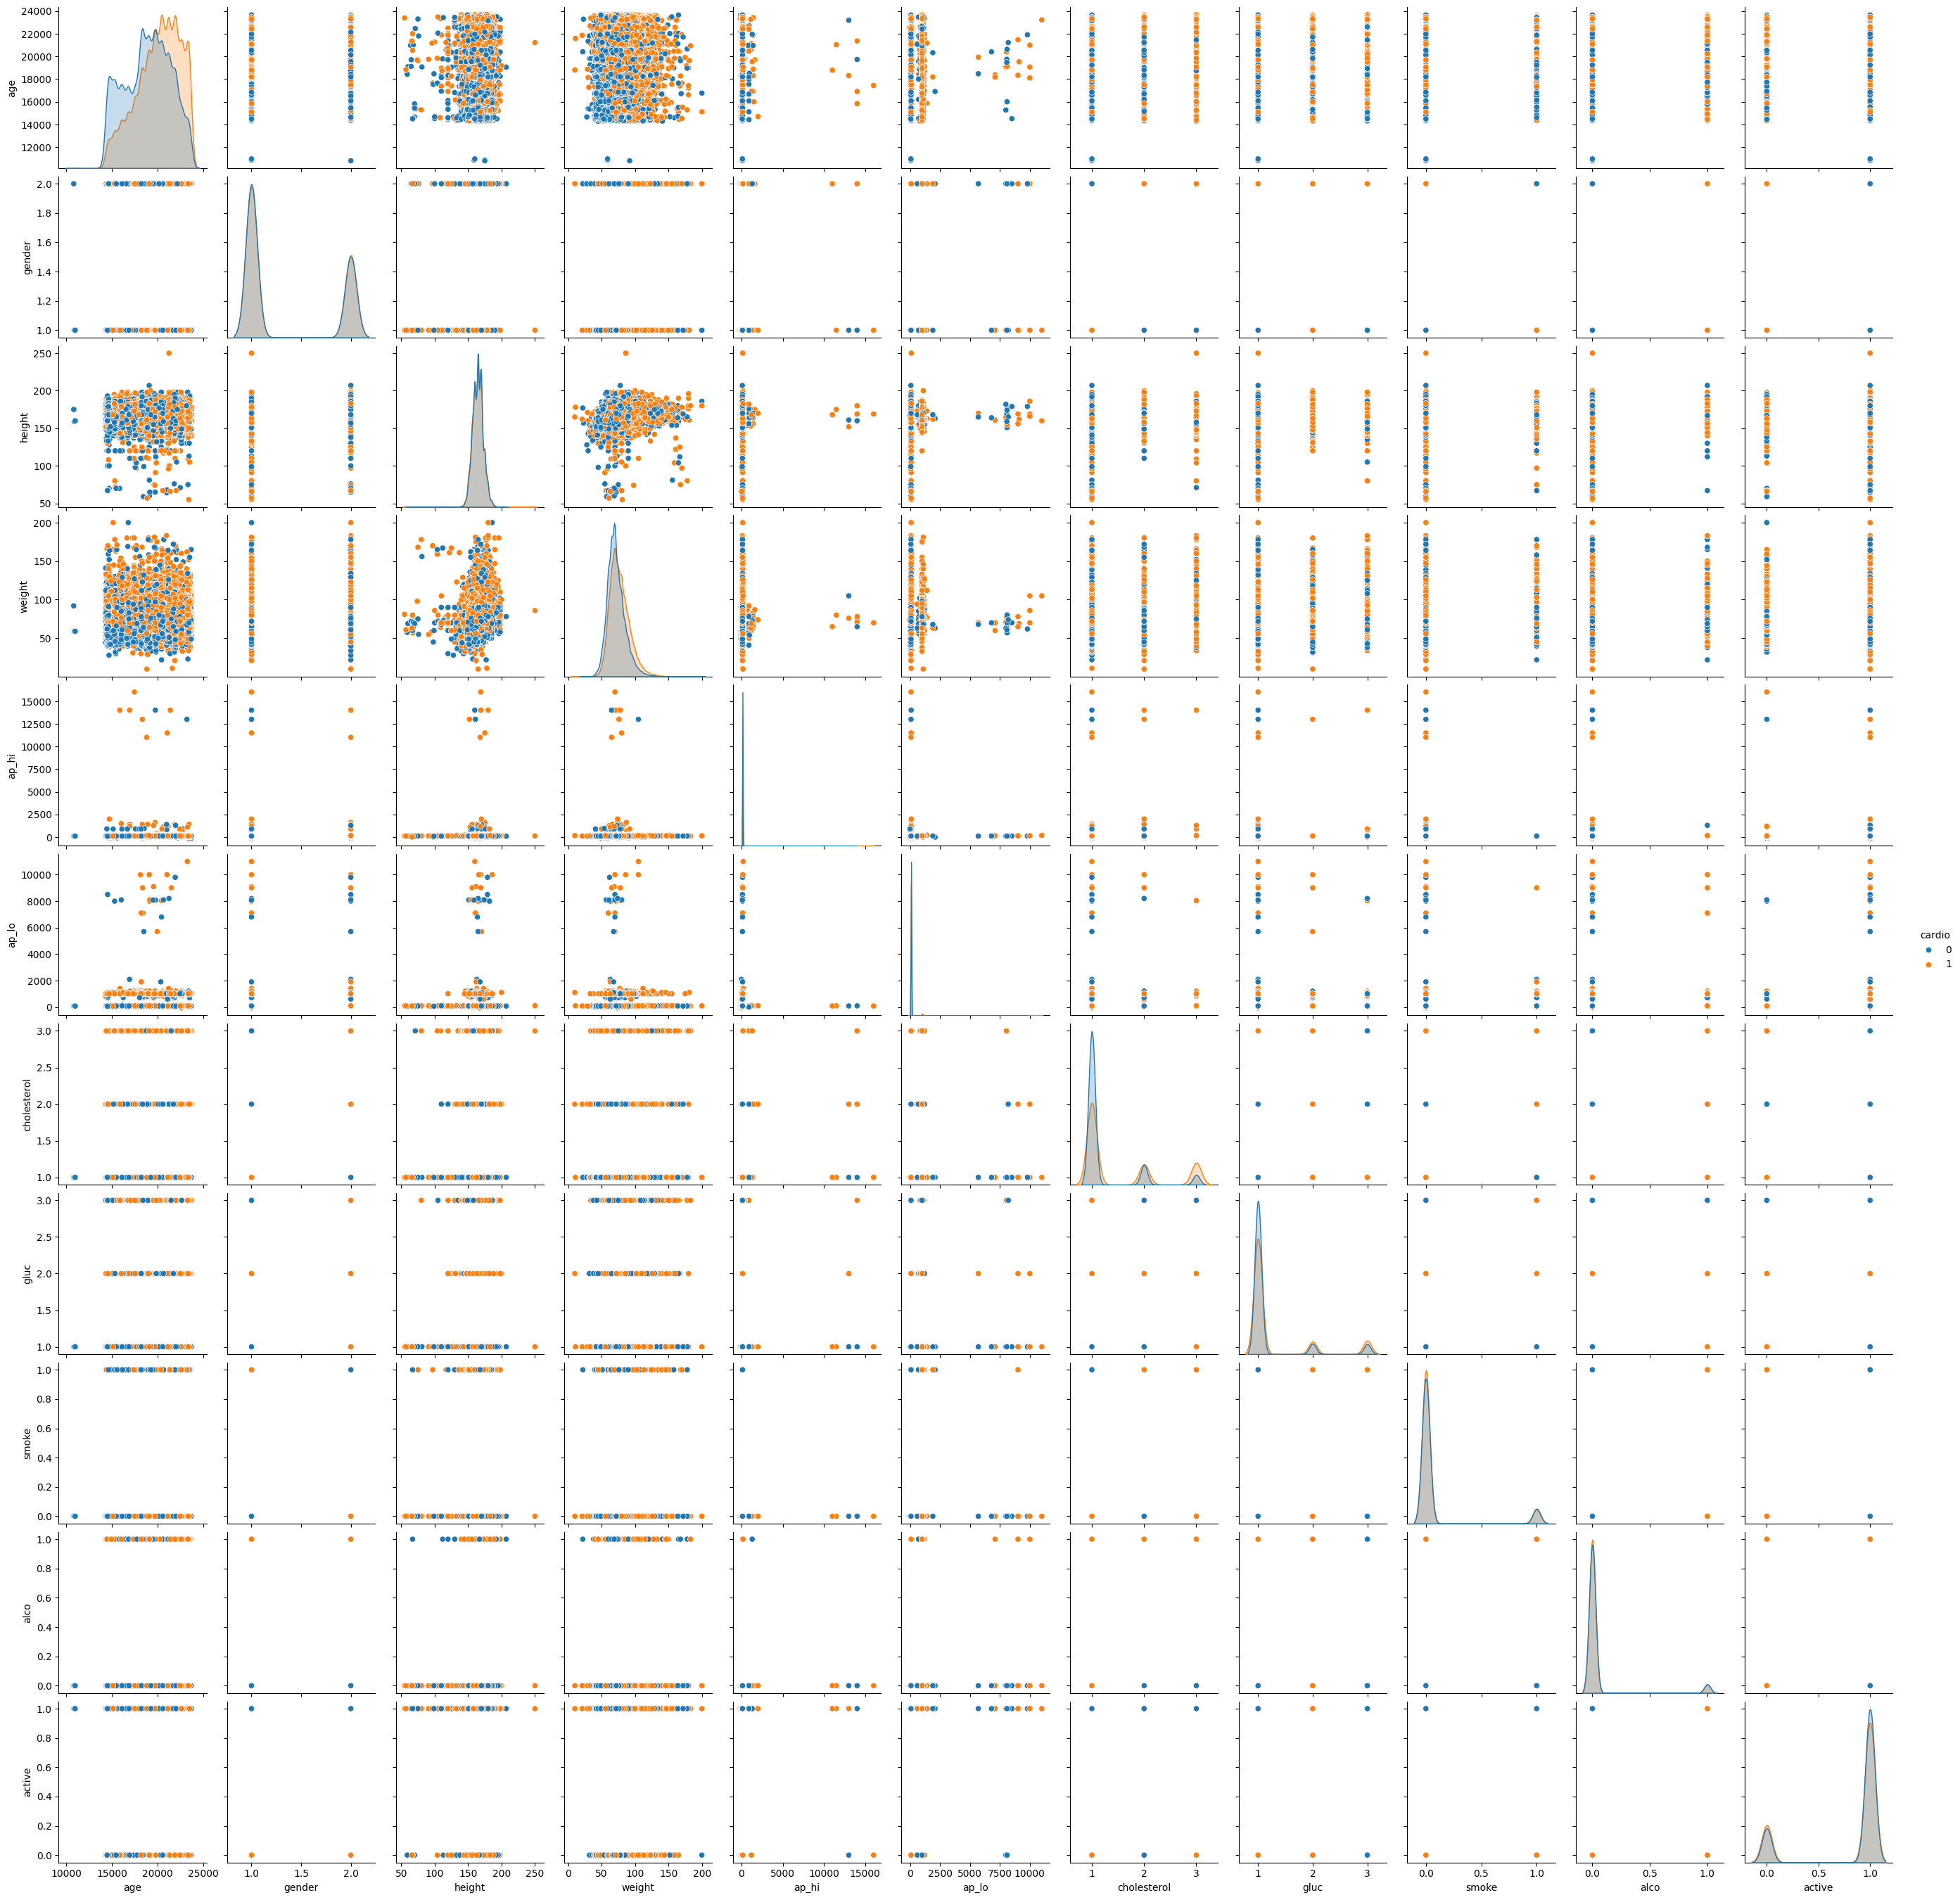

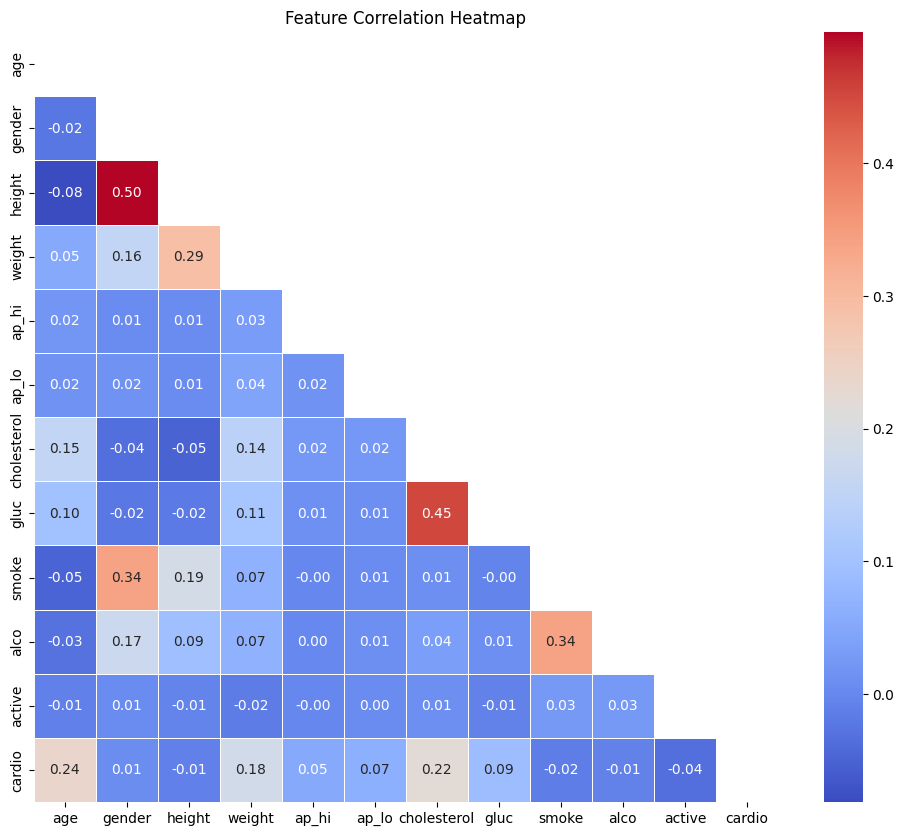

Medical anomalies found: 1309
Total outliers found: 1416


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('cardio_train.csv', sep=";")
# id sütununu sil
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

df.info()
print("\nEksik değerler:\n", df.isnull().sum())
describe = df.describe()

sns.pairplot(df, hue="cardio")
plt.show()

def plot_correlation_heatmap(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", mask=mask)
    plt.title("Feature Correlation Heatmap")
    plt.show()

plot_correlation_heatmap(df)
#aykırı değerler
def detect_outliers_iqr(df):
    outlier_indices = {}
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        if col not in ['cardio', 'gender', 'smoke', 'alco', 'active', 'cholesterol', 'gluc']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.0 * IQR
            upper_bound = Q3 + 2.0 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices[col] = list(outliers)

    all_outliers = set()
    for col, indices in outlier_indices.items():
        all_outliers.update(indices)

    print(f"Total outliers found: {len(all_outliers)}")
    return df.drop(index=all_outliers).reset_index(drop=True)

def detect_medical_anomalies(df):
    anomalies = []

    anomalies.extend(df[(df['ap_hi'] < 0) | (df['ap_hi'] > 250)].index)
    anomalies.extend(df[(df['ap_lo'] < 0) | (df['ap_lo'] > 200)].index)
    anomalies.extend(df[(df['height'] < 100) | (df['height'] > 220)].index)
    anomalies.extend(df[(df['weight'] < 30) | (df['weight'] > 200)].index)

    diastolic_higher = df[df['ap_lo'] > df['ap_hi']].index
    anomalies.extend(diastolic_higher)

    unique_anomalies = list(set(anomalies))
    print(f"Medical anomalies found: {len(unique_anomalies)}")
    return df.drop(index=unique_anomalies).reset_index(drop=True)

df = detect_medical_anomalies(df)
df_cleaned = detect_outliers_iqr(df)

df_cleaned['age_years'] = df_cleaned['age'] / 365
df_cleaned.drop('age', axis=1, inplace=True)

df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)
df_cleaned['bp_diff'] = df_cleaned['ap_hi'] - df_cleaned['ap_lo']
df_cleaned['bp_product'] = df_cleaned['ap_hi'] * df_cleaned['ap_lo'] / 100
df_cleaned['height_to_weight_ratio'] = df_cleaned['height'] / df_cleaned['weight']
df_cleaned['is_hypertension'] = ((df_cleaned['ap_hi'] >= 140) | (df_cleaned['ap_lo'] >= 90)).astype(int)
df_cleaned['map_bp'] = (df_cleaned['ap_lo'] + (1/3) * (df_cleaned['ap_hi'] - df_cleaned['ap_lo']))

min_bmi = df_cleaned['bmi'].min()
max_bmi = df_cleaned['bmi'].max()
bmi_bins = [min_bmi, 18.5, 24.9, 29.9, 34.9, max_bmi]
df_cleaned['bmi_category'] = pd.cut(df_cleaned['bmi'], bins=bmi_bins, labels=[0, 1, 2, 3, 4], include_lowest=True)

age_bins = [0, 30, 40, 45, 50, 55, 60, 65, 100]
df_cleaned['age_category'] = pd.cut(df_cleaned['age_years'], bins=age_bins, labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)

df_cleaned['bp_category'] = 0
df_cleaned.loc[((df_cleaned['ap_hi'] >= 120) & (df_cleaned['ap_hi'] < 130)) | ((df_cleaned['ap_lo'] >= 80) & (df_cleaned['ap_lo'] < 85)), 'bp_category'] = 1
df_cleaned.loc[((df_cleaned['ap_hi'] >= 130) & (df_cleaned['ap_hi'] < 140)) | ((df_cleaned['ap_lo'] >= 85) & (df_cleaned['ap_lo'] < 90)), 'bp_category'] = 2
df_cleaned.loc[(df_cleaned['ap_hi'] >= 140) | (df_cleaned['ap_lo'] >= 90), 'bp_category'] = 3

risk_factors = ['cholesterol', 'gluc', 'smoke', 'alco', 'is_hypertension']
df_cleaned['risk_score'] = df_cleaned[risk_factors].sum(axis=1)

def risk_index(row):
    score = 0
    if row['bmi'] > 25:
        score += 1
    if row['cholesterol'] > 1:
        score += row['cholesterol'] - 1
    if row['gluc'] > 1:
        score += row['gluc'] - 1
    if row['is_hypertension'] == 1:
        score += 2
    if row['smoke'] == 1:
        score += 1
    if row['alco'] == 1:
        score += 1
    if row['active'] == 0:
        score += 1
    if row['age_years'] > 50:
        score += 1
    if row['gender'] == 2:  # Assuming 2 is male
        score += 1
    return score

df_cleaned['health_risk_index'] = df_cleaned.apply(risk_index, axis=1)

one_hot_columns = []
ordinal_columns = ['bmi_category', 'age_category', 'bp_category', 'cholesterol', 'gluc']

ord_enc = OrdinalEncoder()
df_cleaned[ordinal_columns] = ord_enc.fit_transform(df_cleaned[ordinal_columns])

if one_hot_columns:
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    ohe_encoded = ohe.fit_transform(df_cleaned[one_hot_columns])
    ohe_encoded_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(one_hot_columns))
    df_cleaned = pd.concat([df_cleaned, ohe_encoded_df], axis=1)
    df_cleaned.drop(columns=one_hot_columns, inplace=True)

cols_to_scale = ['height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bp_diff', 'bp_product',
                 'height_to_weight_ratio', 'map_bp', 'age_years', 'health_risk_index', 'risk_score']

scaler = StandardScaler()
df_cleaned[cols_to_scale] = scaler.fit_transform(df_cleaned[cols_to_scale])

X = df_cleaned.drop(["cardio"], axis=1)
y = df_cleaned["cardio"]

polynomial_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = polynomial_features.fit_transform(X)
X_poly_df = pd.DataFrame(X_poly, columns=polynomial_features.get_feature_names_out(X.columns))

# DataFrame'leri birleştir ve numpy array'e dönüştür
X_combined = pd.concat([X.reset_index(drop=True), X_poly_df], axis=1)
X_combined_array = X_combined.values

X_train, X_test, y_train, y_test = train_test_split(X_combined_array, y, test_size=0.2, random_state=42, stratify=y)

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)



LR : F1-score:0.9580, std:0.0027
DT : F1-score:0.9601, std:0.0016
KNN : F1-score:0.9712, std:0.0022
NB : F1-score:0.9216, std:0.0037
RF : F1-score:0.9717, std:0.0019
AdaB : F1-score:0.9542, std:0.0022
GBM : F1-score:0.9666, std:0.0028
SVM : F1-score:0.9593, std:0.0019
XGB : F1-score:0.9653, std:0.0028
[LightGBM] [Info] Number of positive: 8161, number of negative: 7601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36652
[LightGBM] [Info] Number of data points in the train set: 15762, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517764 -> initscore=0.071087
[LightGBM] [Info] Start training from score 0.071087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

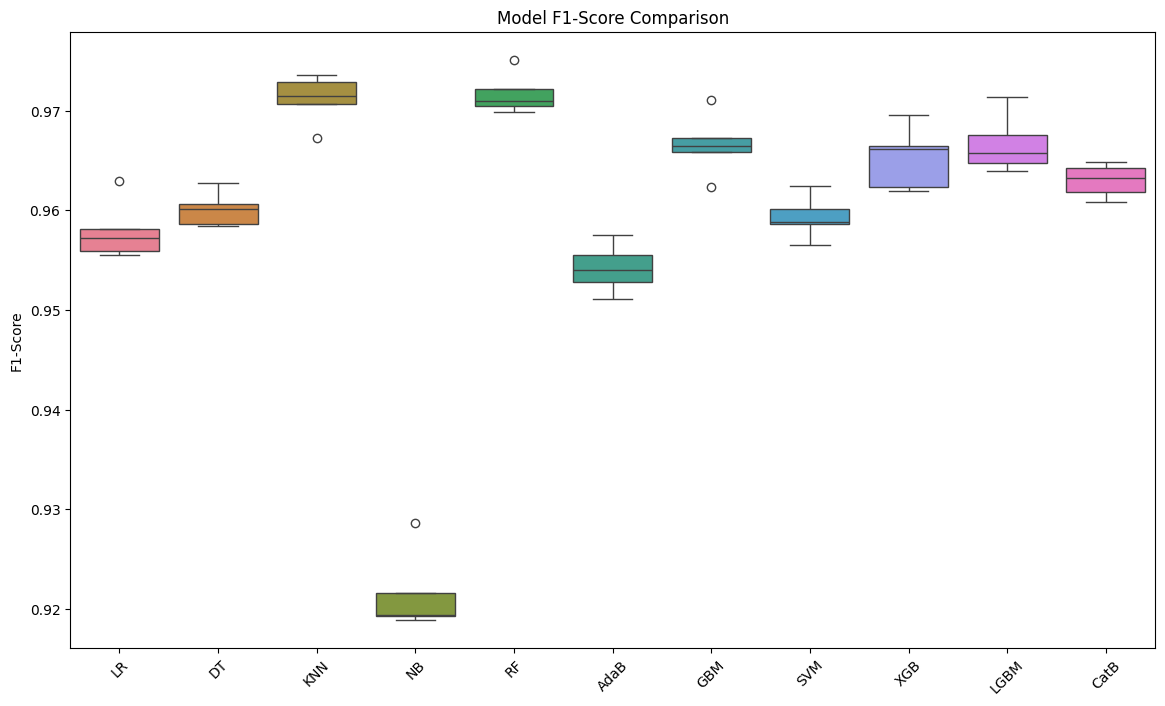

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best F1 score: 0.9741

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455


Confusion Matrix:


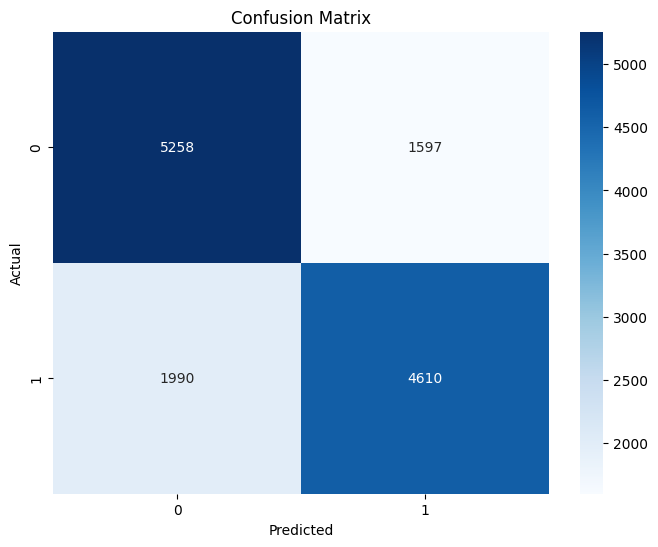

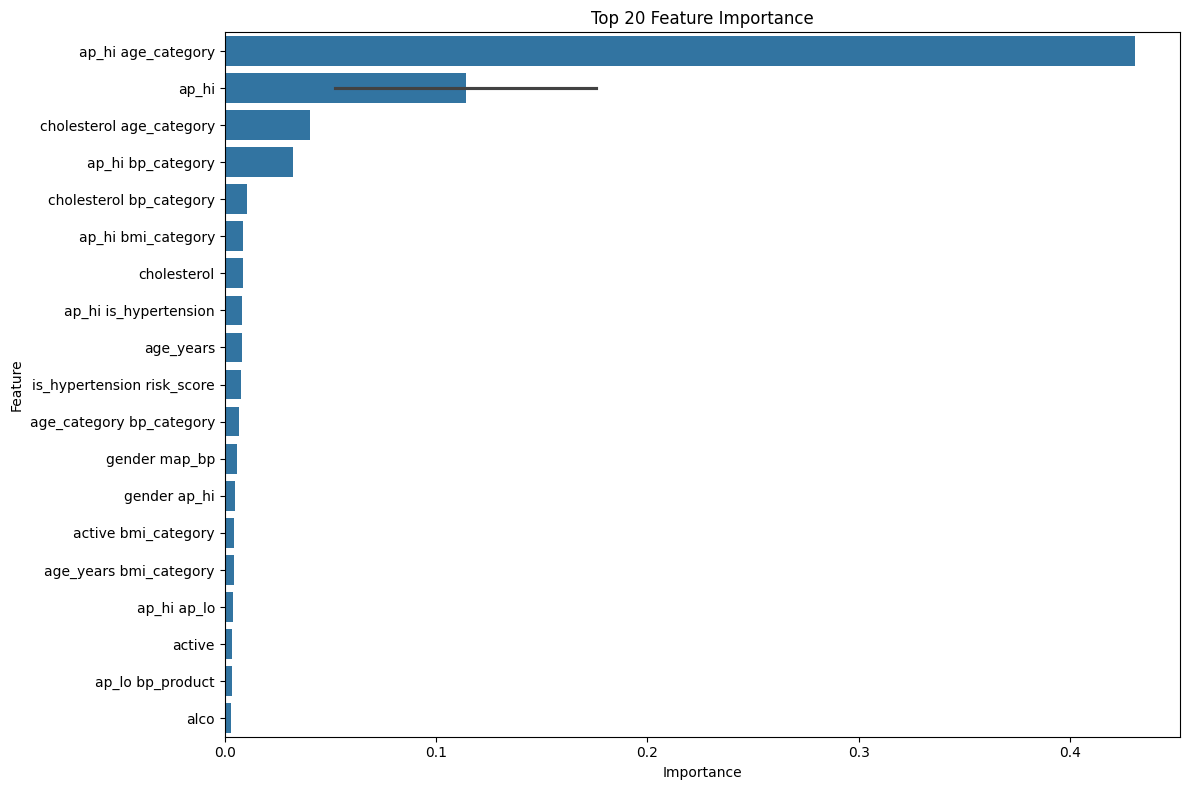

[LightGBM] [Info] Number of positive: 10201, number of negative: 9502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4515
[LightGBM] [Info] Number of data points in the train set: 19703, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517738 -> initscore=0.070983
[LightGBM] [Info] Start training from score 0.070983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      6855
           1       0.75      0.70      0.72      6600

    accuracy                           0.74     13455
   macro avg       0.74      0.74      0.74     13455
weighted avg       0.74      0.74      0.74     13455

F1 Score: 0.7227
=== Bagging Classifier ===
              precision 

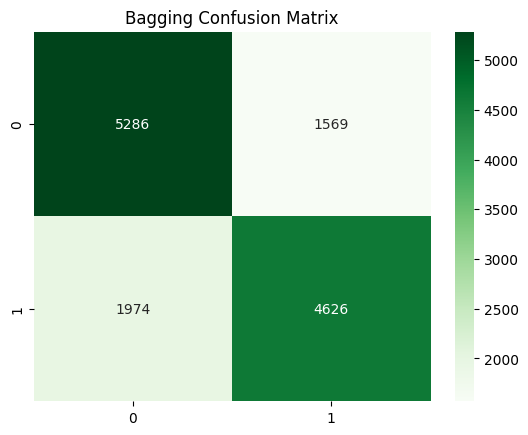

=== Stacking Ensemble Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      6855
           1       0.74      0.71      0.72      6600

    accuracy                           0.74     13455
   macro avg       0.74      0.74      0.74     13455
weighted avg       0.74      0.74      0.74     13455



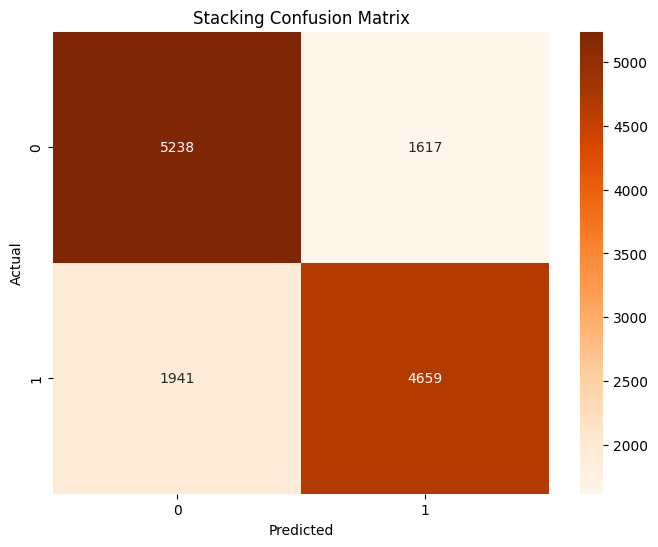

In [6]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
def getBasedModel():
    return [
        ("LR", LogisticRegression(max_iter=1000, C=0.1, solver='liblinear')),
        ("DT", DecisionTreeClassifier(max_depth=10, min_samples_split=5)),
        ("KNN", KNeighborsClassifier(n_neighbors=15, weights='distance')),
        ("NB", GaussianNB()),
        ("RF", RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)),
        ("AdaB", AdaBoostClassifier(n_estimators=100, random_state=42)),
        ("GBM", GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ("SVM", SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')),
        ("XGB", XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
        ("LGBM", LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
        ("CatB", CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_seed=42, verbose=0))
    ]

def baseModelTraining(X_train, y_train, models):
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="f1")
        results.append(cv_results)
        names.append(name)
        print(f"{name} : F1-score:{cv_results.mean():.4f}, std:{cv_results.std():.4f}")
    return names, results

def plot_box(names, results):
    df = pd.DataFrame({names[i]: results[i] for i in range(len(names))})
    plt.figure(figsize=(14,8))
    sns.boxplot(data=df)
    plt.title("Model F1-Score Comparison")
    plt.ylabel("F1-Score")
    plt.xticks(rotation=45)
    plt.show()

models = getBasedModel()
names, results = baseModelTraining(X_train_resampled, y_train_resampled, models)
plot_box(names, results)

xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

xgb_model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.4f}")

best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Özellik önemini hesaplamak için sütun adlarını geri al
feature_names = X_combined.columns if isinstance(X_combined, pd.DataFrame) else [f'feature_{i}' for i in range(X_combined_array.shape[1])]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# En önemli özellikleri seç
top_features_indices = feature_importance['Importance'].argsort()[-50:][::-1]
X_train_top = X_train_resampled[:, top_features_indices]
X_test_top = X_test[:, top_features_indices]

best_models = [
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)),
    ('XGB', XGBClassifier(**random_search.best_params_)),
    ('LGBM', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)),
    ('CatB', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

voting_classifier = VotingClassifier(estimators=best_models, voting='soft')
voting_classifier.fit(X_train_top, y_train_resampled)

y_pred_voting = voting_classifier.predict(X_test_top)
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred_voting))

print(f"F1 Score: {f1_score(y_test, y_pred_voting):.4f}")
# --- Bagging ---
bagging = BaggingClassifier(
    estimator=best_xgb_model,
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
bagging.fit(X_train_top, y_train_resampled)
print("=== Bagging Classifier ===")
print(classification_report(y_test, bagging.predict(X_test_top)))
cm = confusion_matrix(y_test, bagging.predict(X_test_top))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Bagging Confusion Matrix')
plt.show()

# --- Stacking ---
# 11. Stacking
stack = StackingClassifier(
    estimators=best_models,                       # [('RF', rf), ('XGB', xgb), …]
    final_estimator=LogisticRegression(max_iter=1000, C=1.0),
    cv=5,
    passthrough=False,
    n_jobs=-1
)
stack.fit(X_train_top, y_train_resampled)

y_pred_stack = stack.predict(X_test_top)
print("=== Stacking Ensemble Classification Report ===")
print(classification_report(y_test, y_pred_stack))

cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(8,6))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Oranges')
plt.title('Stacking Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
print("\nX_train başı:")
print(X_train.head())
print("\nX_train sütunları:")
print(X_train.columns)

print("\nX_test başı:")
print(X_test.head())
print("\nX_test sütunları:")
print(X_test.columns)


X_train başı:
       gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
51725       1     158    65.0    120     90          0.0   0.0      0     0   
51319       2     163    82.0    150     80          0.0   0.0      0     0   
65318       2     184    86.0    120     80          0.0   0.0      0     0   
701         2     183    91.0    130     80          1.0   0.0      0     0   
26610       2     161    90.0    130     80          2.0   0.0      0     0   

       active  age_years        bmi  is_hypertension  \
51725       1  55.635616  26.037494                1   
51319       1  43.871233  30.863036                1   
65318       1  52.123288  25.401701                0   
701         1  40.128767  27.173102                0   
26610       1  61.920548  34.720883                0   

       health_risk_index_weighted  
51725                           8  
51319                           6  
65318                           2  
701                          

XGBoost (Orijinal + Ağırlıklı Risk Skoru) Raporu:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455

F1 Skoru: 0.7194


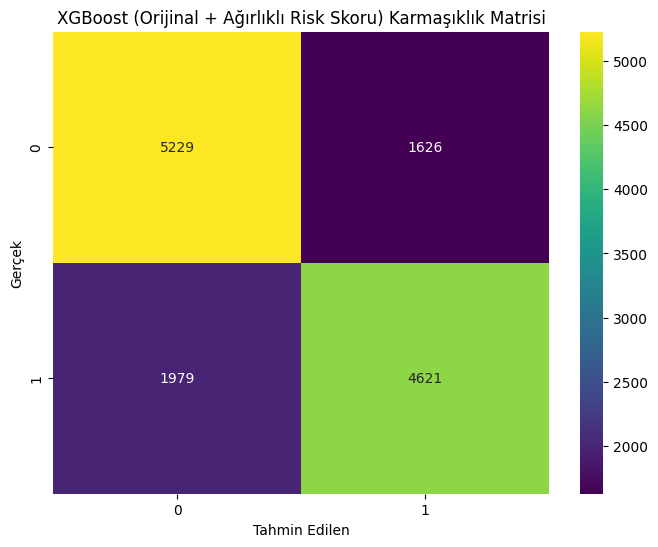

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.combine import SMOTEENN

# Geliştirilmiş risk skoru fonksiyonu (ağırlıklar eklendi)
def improved_risk_score_weighted(row):
    score = 0
    if row['bmi'] > 25:
        score += 1
    if row['cholesterol'] > 1:
        score += 3  # Kolesterole daha yüksek ağırlık
    if row['gluc'] > 1:
        score += 2
    if row['is_hypertension'] == 1:
        score += 4  # Hipertansiyona daha yüksek ağırlık
    if row['smoke'] == 1:
        score += 2
    if row['alco'] == 1:
        score += 1
    if row['active'] == 0:
        score += 1
    if row['age_years'] > 55:
        score += 3  # Yaşa daha yüksek ağırlık
    if row['gender'] == 2:  # Erkek
        score += 1
    return score

# Veri setini tekrar yükleme ve temizleme (önceki adımlar)
df = pd.read_csv('cardio_train.csv', sep=";")
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

def detect_medical_anomalies(df):
    anomalies = []
    anomalies.extend(df[(df['ap_hi'] < 0) | (df['ap_hi'] > 250)].index)
    anomalies.extend(df[(df['ap_lo'] < 0) | (df['ap_lo'] > 200)].index)
    anomalies.extend(df[(df['height'] < 100) | (df['height'] > 220)].index)
    anomalies.extend(df[(df['weight'] < 30) | (df['weight'] > 200)].index)
    diastolic_higher = df[df['ap_lo'] > df['ap_hi']].index
    anomalies.extend(diastolic_higher)
    unique_anomalies = list(set(anomalies))
    return df.drop(index=unique_anomalies).reset_index(drop=True)

def detect_outliers_iqr(df):
    outlier_indices = {}
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        if col not in ['cardio', 'gender', 'smoke', 'alco', 'active', 'cholesterol', 'gluc']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.0 * IQR
            upper_bound = Q3 + 2.0 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices[col] = list(outliers)
    all_outliers = set()
    for col, indices in outlier_indices.items():
        all_outliers.update(indices)
    return df.drop(index=all_outliers).reset_index(drop=True)

df = detect_medical_anomalies(df)
df_cleaned = detect_outliers_iqr(df)
df_cleaned['age_years'] = df_cleaned['age'] / 365
df_cleaned.drop('age', axis=1, inplace=True)
df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)
df_cleaned['is_hypertension'] = ((df_cleaned['ap_hi'] >= 140) | (df_cleaned['ap_lo'] >= 90)).astype(int)
df_cleaned['health_risk_index_weighted'] = df_cleaned.apply(improved_risk_score_weighted, axis=1)

# Kategorik değişkenleri ordinal encoding ile sayısal hale getirme (önceki koddan)
ordinal_cols = ['cholesterol', 'gluc']
ord_enc = OrdinalEncoder(categories=[[1, 2, 3], [1, 2, 3]])
df_cleaned[ordinal_cols] = ord_enc.fit_transform(df_cleaned[ordinal_cols])

# Veri setini eğitim ve test kümelerine ayırma
X = df_cleaned.drop(["cardio"], axis=1)
y = df_cleaned["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE-ENN ile dengeleme
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Yeni risk skoru ile XGBoost modelini eğitme
xgb_model_with_weighted_risk = XGBClassifier(random_state=42)

# SMOTEENN uygulanmış verilere göre risk skorunu alıp yeniden boyutlandırın
train_risk_score = df_cleaned.loc[X_train_resampled.index, 'health_risk_index_weighted'].values.reshape(-1, 1)
test_risk_score = df_cleaned.loc[X_test.index, 'health_risk_index_weighted'].values.reshape(-1, 1)

# Ölçeklenmiş eğitim verisi ile risk skorunu birleştirin
X_train_weighted_risk = np.concatenate((X_train_scaled, train_risk_score), axis=1)
X_test_weighted_risk = np.concatenate((X_test_scaled, test_risk_score), axis=1)

xgb_model_with_weighted_risk.fit(X_train_weighted_risk, y_train_resampled)
y_pred_weighted_risk = xgb_model_with_weighted_risk.predict(X_test_weighted_risk)

print("XGBoost (Orijinal + Ağırlıklı Risk Skoru) Raporu:")
print(classification_report(y_test, y_pred_weighted_risk))
print(f"F1 Skoru: {f1_score(y_test, y_pred_weighted_risk):.4f}")

# Karmaşıklık Matrisi
cm_weighted_risk = confusion_matrix(y_test, y_pred_weighted_risk)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_weighted_risk, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('XGBoost (Orijinal + Ağırlıklı Risk Skoru) Karmaşıklık Matrisi')
plt.show()

In [14]:
df_cleaned.head()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67275 entries, 0 to 67274
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      67275 non-null  int64  
 1   height                      67275 non-null  int64  
 2   weight                      67275 non-null  float64
 3   ap_hi                       67275 non-null  int64  
 4   ap_lo                       67275 non-null  int64  
 5   cholesterol                 67275 non-null  float64
 6   gluc                        67275 non-null  float64
 7   smoke                       67275 non-null  int64  
 8   alco                        67275 non-null  int64  
 9   active                      67275 non-null  int64  
 10  cardio                      67275 non-null  int64  
 11  age_years                   67275 non-null  float64
 12  bmi                         67275 non-null  float64
 13  is_hypertension             672

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Bagging Classifier (Random Forest tabanlı) ---
bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Modeli eğit
bagging_model.fit(X_train, y_train)

# Tahmin yap
y_pred_bagging = bagging_model.predict(X_test)

# Doğruluk oranı
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"\nBagging Classifier Doğruluk Oranı: {accuracy_bagging:.4f}")

# Sınıflandırma raporu
print("\nBagging Classifier Classification Report:")
print(classification_report(y_test, y_pred_bagging))

# Karışıklık matrisi
print("Bagging Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bagging))


Bagging Classifier Doğruluk Oranı: 0.7215

Bagging Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6855
           1       0.73      0.70      0.71      6600

    accuracy                           0.72     13455
   macro avg       0.72      0.72      0.72     13455
weighted avg       0.72      0.72      0.72     13455

Bagging Classifier Confusion Matrix:
[[5119 1736]
 [2011 4589]]


Fitting 5 folds for each of 10 candidates, totalling 50 fits

En İyi Hiperparametreler: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}
En İyi F1 Skoru: 0.9649433854652723

En İyi XGBoost Modeli Test Performansı:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455

F1 Skoru: 0.7184


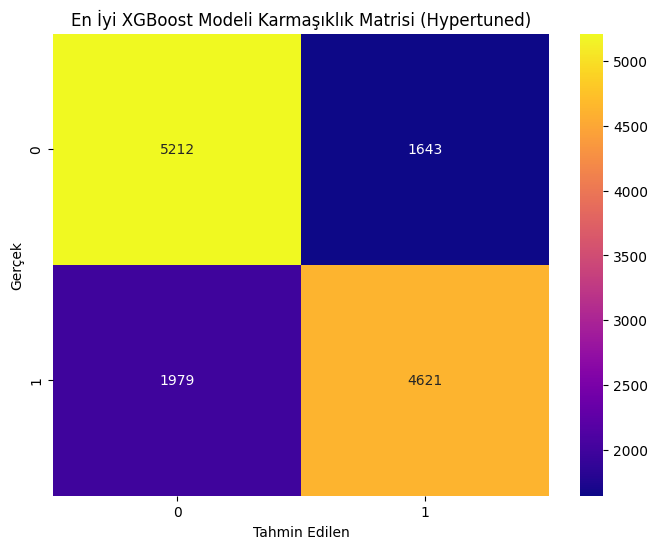

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hiperparametre aralıkları
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [1, 0.1, 0.01, 0.001, 0]
}

# XGBoost modelini oluştur
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Stratified K-Fold çapraz doğrulama nesnesi oluştur
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV nesnesi oluştur
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Denenecek rastgele kombinasyon sayısı (ayarlanabilir)
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ölçeklenmiş eğitim verisi ve risk skoru ile modeli eğit
random_search.fit(X_train_weighted_risk, y_train_resampled)

# En iyi hiperparametreleri ve en iyi skoru yazdır
print("\nEn İyi Hiperparametreler:", random_search.best_params_)
print("En İyi F1 Skoru:", random_search.best_score_)

# En iyi modeli al
best_xgb_model = random_search.best_estimator_

# En iyi model ile test verisi üzerinde tahmin yap
y_pred_best_xgb = best_xgb_model.predict(X_test_weighted_risk)

# Test performansı değerlendirmesi
print("\nEn İyi XGBoost Modeli Test Performansı:")
print(classification_report(y_test, y_pred_best_xgb))
print(f"F1 Skoru: {f1_score(y_test, y_pred_best_xgb):.4f}")

# Karmaşıklık Matrisi
cm_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_xgb, annot=True, fmt='d', cmap='plasma')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('En İyi XGBoost Modeli Karmaşıklık Matrisi (Hypertuned)')
plt.show()


Voting Classifier Doğruluk Oranı: 0.7312

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6855
           1       0.75      0.68      0.71      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455



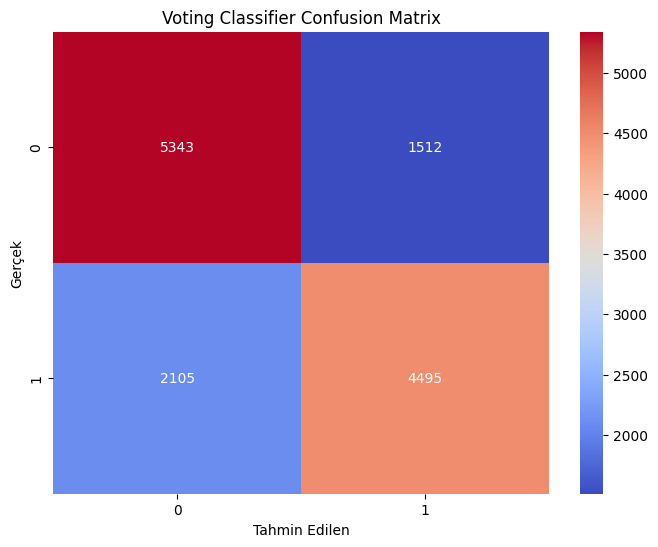

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Daha önce eğitilmiş XGBoost (ağırlıklı risk skorlu) modelini al
# Eğer en iyi parametrelerle eğittiyseniz o modeli kullanın
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: xgb_model_with_weighted_risk

# Daha önce eğitilmiş Bagging Classifier modelini al
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: bagging_model

# VotingClassifier oluşturma
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model_with_weighted_risk), ('bagging', bagging_model)],
    voting='hard'  # 'hard' oylama: her modelin sınıf tahminine göre çoğunluk oyu
)

# Modeli eğit
voting_clf.fit(X_train_weighted_risk, y_train_resampled)

# Tahmin yap
y_pred_voting = voting_clf.predict(X_test_weighted_risk)

# Doğruluk oranı
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"\nVoting Classifier Doğruluk Oranı: {accuracy_voting:.4f}")

# Sınıflandırma raporu
print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))

# Karışıklık matrisi
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Voting Classifier Confusion Matrix')
plt.show()


Voting Classifier (Soft) Doğruluk Oranı: 0.7328

Voting Classifier (Soft) Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455



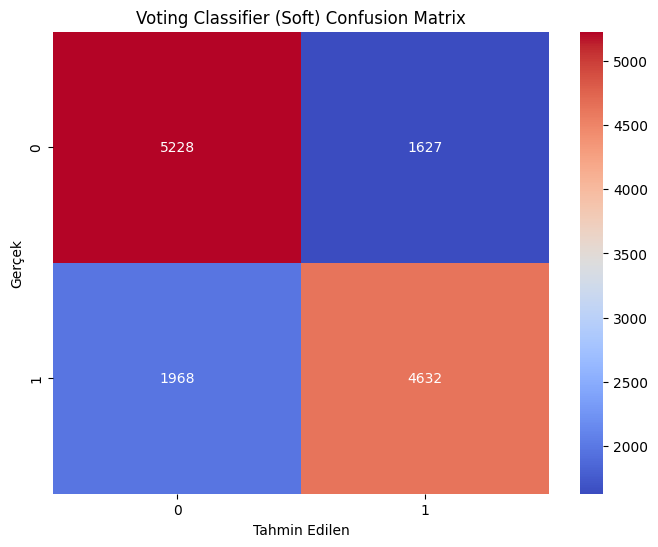

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Daha önce eğitilmiş XGBoost (ağırlıklı risk skorlu) modelini al
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: xgb_model_with_weighted_risk

# Daha önce eğitilmiş Bagging Classifier modelini al
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: bagging_model

# VotingClassifier oluşturma (soft voting ile)
voting_clf_soft = VotingClassifier(
    estimators=[('xgb', xgb_model_with_weighted_risk), ('bagging', bagging_model)],
    voting='soft'  # 'soft' oylama: olasılıkların ağırlıklı ortalaması
)

# Modeli eğit
voting_clf_soft.fit(X_train_weighted_risk, y_train_resampled)

# Tahmin yap
y_pred_voting_soft = voting_clf_soft.predict(X_test_weighted_risk)

# Doğruluk oranı
accuracy_voting_soft = accuracy_score(y_test, y_pred_voting_soft)
print(f"\nVoting Classifier (Soft) Doğruluk Oranı: {accuracy_voting_soft:.4f}")

# Sınıflandırma raporu
print("\nVoting Classifier (Soft) Classification Report:")
print(classification_report(y_test, y_pred_voting_soft))

# Karışıklık matrisi
cm_voting_soft = confusion_matrix(y_test, y_pred_voting_soft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting_soft, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Voting Classifier (Soft) Confusion Matrix')
plt.show()


Voting Classifier (Soft) Ağırlıklar: [0.6, 0.4] - Doğruluk Oranı: 0.7330
Voting Classifier (Soft) Ağırlıklar: [0.6, 0.4] - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455



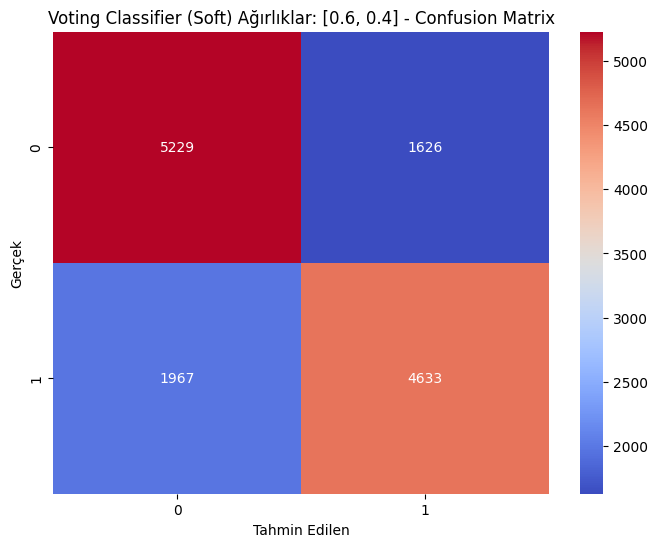


Voting Classifier (Soft) Ağırlıklar: [0.7, 0.3] - Doğruluk Oranı: 0.7327
Voting Classifier (Soft) Ağırlıklar: [0.7, 0.3] - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455



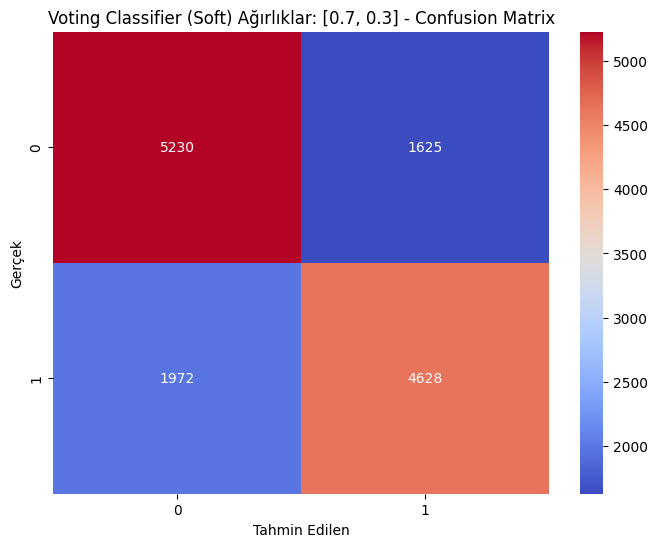


Voting Classifier (Soft) Ağırlıklar: [0.4, 0.6] - Doğruluk Oranı: 0.7330
Voting Classifier (Soft) Ağırlıklar: [0.4, 0.6] - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      6855
           1       0.74      0.70      0.72      6600

    accuracy                           0.73     13455
   macro avg       0.73      0.73      0.73     13455
weighted avg       0.73      0.73      0.73     13455



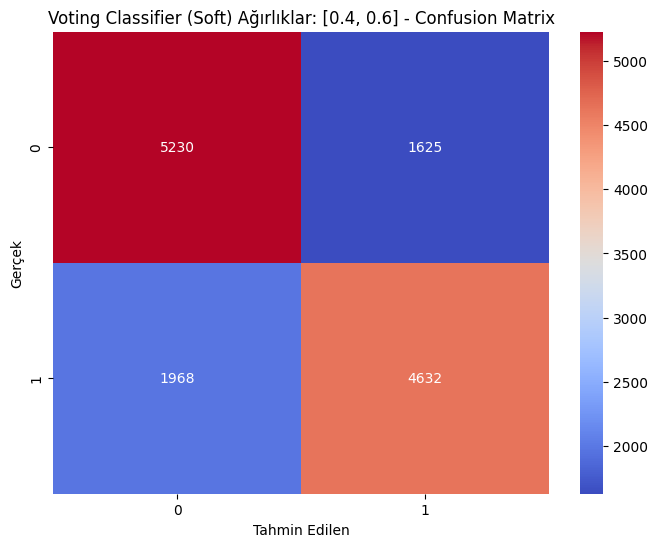

In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Daha önce eğitilmiş XGBoost (ağırlıklı risk skorlu) modelini al
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: xgb_model_with_weighted_risk

# Daha önce eğitilmiş Bagging Classifier modelini al
# Şu anki durumda, en son eğitilmiş modeli varsayıyoruz: bagging_model

# Denenecek ağırlık kombinasyonları
weights_combinations = [
    [0.6, 0.4],
    [0.7, 0.3],
    [0.4, 0.6],
]

for weights in weights_combinations:
    # VotingClassifier oluşturma (soft voting ile farklı ağırlıklarla)
    voting_clf_weighted = VotingClassifier(
        estimators=[('xgb', xgb_model_with_weighted_risk), ('bagging', bagging_model)],
        voting='soft',
        weights=weights
    )

    # Modeli eğit
    voting_clf_weighted.fit(X_train_weighted_risk, y_train_resampled)

    # Tahmin yap
    y_pred_voting_weighted = voting_clf_weighted.predict(X_test_weighted_risk)

    # Doğruluk oranı
    accuracy_voting_weighted = accuracy_score(y_test, y_pred_voting_weighted)
    print(f"\nVoting Classifier (Soft) Ağırlıklar: {weights} - Doğruluk Oranı: {accuracy_voting_weighted:.4f}")

    # Sınıflandırma raporu
    print(f"Voting Classifier (Soft) Ağırlıklar: {weights} - Classification Report:")
    print(classification_report(y_test, y_pred_voting_weighted))

    # Karışıklık matrisi
    cm_voting_weighted = confusion_matrix(y_test, y_pred_voting_weighted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_voting_weighted, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title(f'Voting Classifier (Soft) Ağırlıklar: {weights} - Confusion Matrix')
    plt.show()


Voting Classifier (Seçilmiş Özellikler) Doğruluk Oranı: 0.7272595070166509

Voting Classifier (Seçilmiş Özellikler) Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6949
           1       0.74      0.69      0.71      6804

    accuracy                           0.73     13753
   macro avg       0.73      0.73      0.73     13753
weighted avg       0.73      0.73      0.73     13753



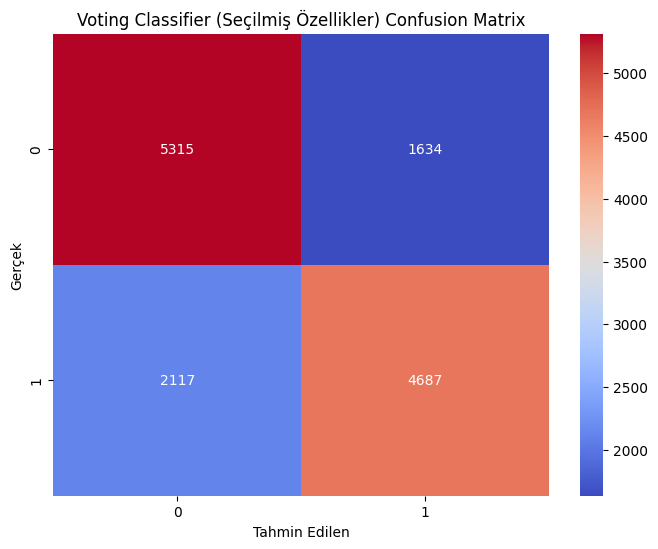

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, StackingClassifier, VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('cardio_train.csv', sep=";")
# id sütununu sil
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

df = df[df['ap_hi'] >= 0]
df = df[df['ap_lo'] >= 0]
df = df[df['height'] >= 0]
df = df[df['weight'] >= 0]

diastolic_higher = df[df['ap_lo'] > df['ap_hi']].index
df.drop(diastolic_higher, inplace=True)

df_cleaned = df.copy()
df_cleaned['age_years'] = (df_cleaned['age'] / 365).round().astype(int)
df_cleaned.drop('age', axis=1, inplace=True)
df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)
df_cleaned['is_hypertension'] = ((df_cleaned['ap_hi'] >= 140) | (df_cleaned['ap_lo'] >= 90)).astype(int)

X = df_cleaned.drop(["cardio"], axis=1)
y = df_cleaned["cardio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Polinom özellikler
polynomial_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_train = polynomial_features.fit_transform(X_train_resampled)
X_poly_test = polynomial_features.transform(X_test)
X_poly_train_df = pd.DataFrame(X_poly_train, columns=polynomial_features.get_feature_names_out(X_train_resampled.columns))
X_poly_test_df = pd.DataFrame(X_poly_test, columns=polynomial_features.get_feature_names_out(X_test.columns))

X_train_combined = pd.concat([pd.DataFrame(X_train_resampled, columns=X_train_resampled.columns).reset_index(drop=True), X_poly_train_df], axis=1).values
X_test_combined = pd.concat([pd.DataFrame(X_test, columns=X_test.columns).reset_index(drop=True), X_poly_test_df], axis=1).values

# XGBoost modelini eğit
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_combined, y_train_resampled)

# Özellik önemini hesapla
feature_importance = pd.DataFrame({
    'Feature': pd.concat([pd.DataFrame(X_train_resampled, columns=X_train_resampled.columns), X_poly_train_df], axis=1).columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# En önemli 10 özelliği seç
top_features = feature_importance['Feature'].head(10).tolist()

# Seçilen özelliklerle yeni veri setleri oluşturma (DataFrame olarak tutalım)
X_train_selected = pd.DataFrame(X_train_combined, columns=pd.concat([pd.DataFrame(X_train_resampled, columns=X_train_resampled.columns), X_poly_train_df], axis=1).columns)[top_features]
X_test_selected = pd.DataFrame(X_test_combined, columns=pd.concat([pd.DataFrame(X_test, columns=X_test.columns), X_poly_test_df], axis=1).columns)[top_features]

# Bagging Classifier (temel model olarak XGBoost ile)
bagging_clf = BaggingClassifier(estimator=xgb_model, n_estimators=50, random_state=42)
bagging_clf.fit(X_train_selected.values, y_train_resampled) # Bagging de NumPy array bekleyebilir

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('bagging', bagging_clf)],
    voting='soft'
)
voting_clf.fit(X_train_selected.values, y_train_resampled) # Voting de NumPy array bekleyebilir

# Tahmin ve değerlendirme
y_pred_selected_voting = voting_clf.predict(X_test_selected.values)
print("\nVoting Classifier (Seçilmiş Özellikler) Doğruluk Oranı:", accuracy_score(y_test, y_pred_selected_voting))
print("\nVoting Classifier (Seçilmiş Özellikler) Classification Report:")
print(classification_report(y_test, y_pred_selected_voting))
cm_selected_voting = confusion_matrix(y_test, y_pred_selected_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_selected_voting, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Voting Classifier (Seçilmiş Özellikler) Confusion Matrix')
plt.show()


Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6949
           1       0.74      0.69      0.71      6804

    accuracy                           0.73     13753
   macro avg       0.73      0.73      0.73     13753
weighted avg       0.73      0.73      0.73     13753

Stacking Ensemble Accuracy: 0.7258052788482513


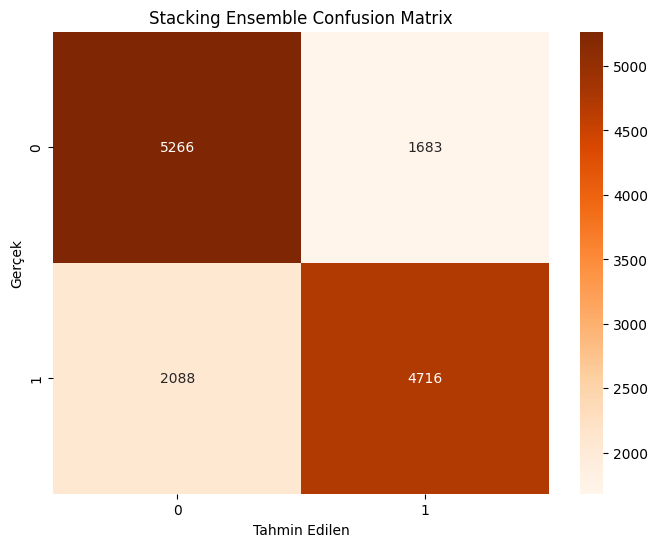

In [29]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Temel modelleri tanımla (önceki en iyi modellerden seçerek)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Meta-modeli tanımla
final_estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# Stacking Classifier'ı oluştur
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,  # Çapraz doğrulama kat sayısı
    passthrough=False, # Temel modellerin orijinal girdilerini meta-modele iletme (isteğe bağlı)
    n_jobs=-1
)

# Modeli eğit
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking = stacking_clf.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking))
print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred_stacking))

cm_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble Confusion Matrix')
plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42, max_iter=500),
                              param_grid_lr,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)

# Stacking modelini (temel modellerle birlikte) grid search ile eğit
# Not: Bu, tüm Stacking yapısının grid search ile eğitilmesini içerir
# Bu işlem uzun sürebilir.

# Geçici olarak sadece meta-modeli optimize etmek için (daha hızlı deneme)
# temel modellerin tahminlerini alıp meta-modeli eğitebiliriz.
base_model_predictions = [model.predict_proba(X_test)[:, 1] for name, model in stacking_clf.named_estimators_.items()]
base_model_predictions = np.array(base_model_predictions).T

grid_search_lr.fit(base_model_predictions, y_test)

print("En iyi C değeri (Lojistik Regresyon):", grid_search_lr.best_params_)
print("En iyi doğruluk oranı (Lojistik Regresyon):", grid_search_lr.best_score_)

# Ardından, en iyi C değeriyle Stacking modelini tekrar eğitebiliriz.
best_lr_meta = LogisticRegression(solver='liblinear', random_state=42, max_iter=500, C=grid_search_lr.best_params_['C'])
stacking_clf_optimized_meta = StackingClassifier(
    estimators=estimators,
    final_estimator=best_lr_meta,
    cv=5,
    passthrough=False,
    n_jobs=-1
)
stacking_clf_optimized_meta.fit(X_train_resampled, y_train_resampled)
y_pred_stacking_optimized_meta = stacking_clf_optimized_meta.predict(X_test)
print("\nStacking Ensemble (Optimize Edilmiş Meta-Model) Accuracy:", accuracy_score(y_test, y_pred_stacking_optimized_meta))

En iyi C değeri (Lojistik Regresyon): {'C': 0.1}
En iyi doğruluk oranı (Lojistik Regresyon): 0.7283505766498133

Stacking Ensemble (Optimize Edilmiş Meta-Model) Accuracy: 0.727186795608231



Stacking Ensemble (XGBoost Meta-Model) Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Stacking Ensemble (XGBoost Meta-Model) Accuracy: 0.723042245328292


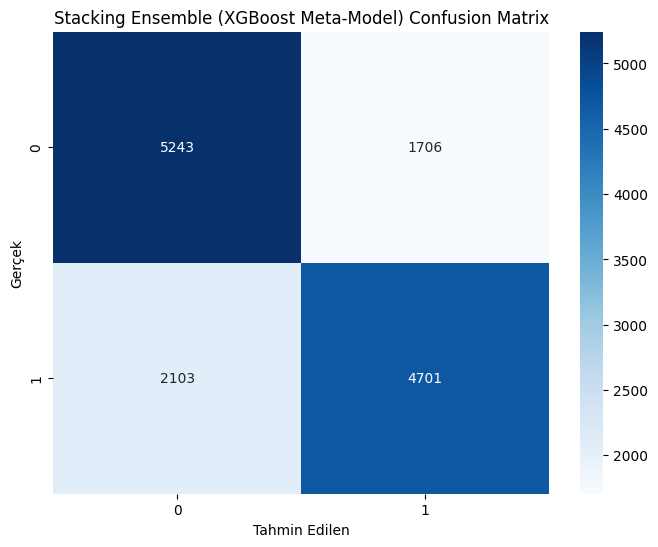

In [31]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Temel modeller (aynı kalabilir)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Yeni meta-model: XGBoost
final_estimator_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Stacking Classifier'ı yeni meta-model ile oluştur
stacking_clf_xgb = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator_xgb,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_xgb.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking_xgb = stacking_clf_xgb.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble (XGBoost Meta-Model) Classification Report:")
print(classification_report(y_test, y_pred_stacking_xgb))
print("Stacking Ensemble (XGBoost Meta-Model) Accuracy:", accuracy_score(y_test, y_pred_stacking_xgb))

cm_stacking_xgb = confusion_matrix(y_test, y_pred_stacking_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble (XGBoost Meta-Model) Confusion Matrix')
plt.show()


Stacking Ensemble (Random Forest Meta-Model) Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Stacking Ensemble (Random Forest Meta-Model) Accuracy: 0.7232603795535519


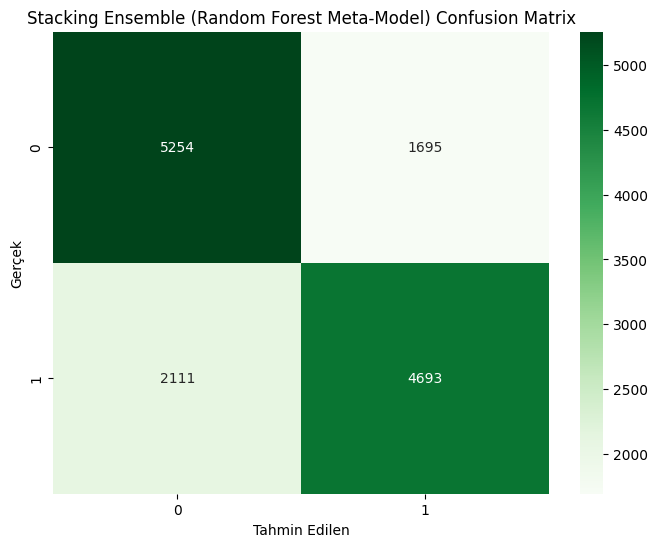

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Temel modeller (aynı kalabilir)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Yeni meta-model: Random Forest
final_estimator_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10) # Başlangıç parametreleri

# Stacking Classifier'ı yeni meta-model ile oluştur
stacking_clf_rf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator_rf,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_rf.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking_rf = stacking_clf_rf.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble (Random Forest Meta-Model) Classification Report:")
print(classification_report(y_test, y_pred_stacking_rf))
print("Stacking Ensemble (Random Forest Meta-Model) Accuracy:", accuracy_score(y_test, y_pred_stacking_rf))

cm_stacking_rf = confusion_matrix(y_test, y_pred_stacking_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble (Random Forest Meta-Model) Confusion Matrix')
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hiperparametre aralığını tanımla
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# GridSearchCV nesnesini oluştur
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                              param_grid_rf,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=2)

# Modeli eğit (hiperparametre kombinasyonlarını dene)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# En iyi hiperparametreleri ve en iyi skoru yazdır
print("En iyi hiperparametreler (Random Forest):", grid_search_rf.best_params_)
print("En iyi doğruluk oranı (Random Forest):", grid_search_rf.best_score_)

# En iyi modeli al
best_rf_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
En iyi hiperparametreler (Random Forest): {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
En iyi doğruluk oranı (Random Forest): 0.9697586611302226



Stacking Ensemble (RF Optimize Edilmiş) Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Stacking Ensemble (RF Optimize Edilmiş) Accuracy: 0.7241329164545918


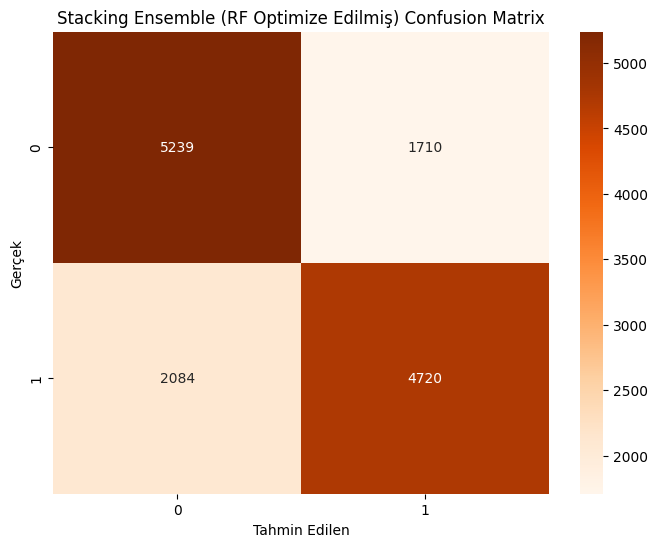

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optimize edilmiş Random Forest modelini kullan
best_rf_model = grid_search_rf.best_estimator_

# Temel modelleri tanımla (Random Forest optimize edilmiş)
estimators = [
    ('rf', best_rf_model),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Meta-modeli tanımla
final_estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# Stacking Classifier'ı oluştur
stacking_clf_optimized_rf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_optimized_rf.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking_optimized_rf = stacking_clf_optimized_rf.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble (RF Optimize Edilmiş) Classification Report:")
print(classification_report(y_test, y_pred_stacking_optimized_rf))
print("Stacking Ensemble (RF Optimize Edilmiş) Accuracy:", accuracy_score(y_test, y_pred_stacking_optimized_rf))

cm_stacking_optimized_rf = confusion_matrix(y_test, y_pred_stacking_optimized_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_optimized_rf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble (RF Optimize Edilmiş) Confusion Matrix')
plt.show()

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Hiperparametre aralığını tanımla
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# RandomizedSearchCV nesnesini oluştur
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                       param_distributions=param_grid_xgb,
                                       n_iter=20,  # Denenecek farklı kombinasyon sayısı
                                       scoring='accuracy',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=2,
                                       random_state=42)

# Modeli eğit (hiperparametre kombinasyonlarını dene)
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# En iyi hiperparametreleri ve en iyi skoru yazdır
print("En iyi hiperparametreler (XGBoost):", random_search_xgb.best_params_)
print("En iyi doğruluk oranı (XGBoost):", random_search_xgb.best_score_)

# En iyi modeli al
best_xgb_model = random_search_xgb.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
En iyi hiperparametreler (XGBoost): {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
En iyi doğruluk oranı (XGBoost): 0.9662851425269092



Stacking Ensemble (RF & XGB Optimize Edilmiş) Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Stacking Ensemble (RF & XGB Optimize Edilmiş) Accuracy: 0.7236239365956518


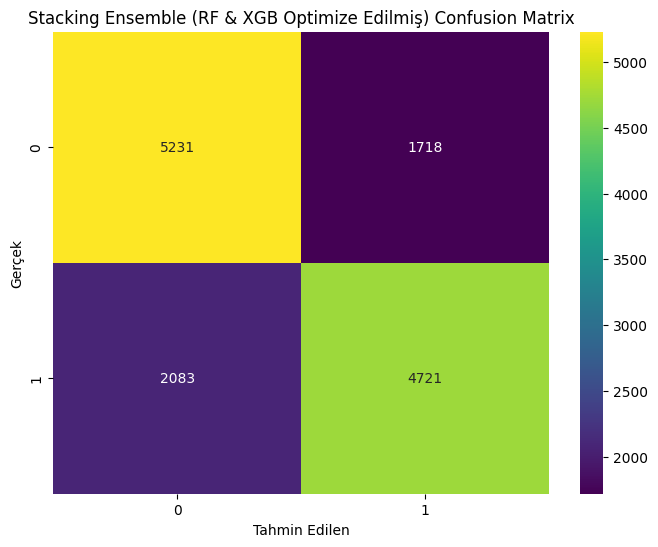

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optimize edilmiş modelleri kullan
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_

# Temel modelleri tanımla (RF ve XGB optimize edilmiş)
estimators = [
    ('rf', best_rf_model),
    ('xgb', best_xgb_model),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Meta-modeli tanımla
final_estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# Stacking Classifier'ı oluştur
stacking_clf_optimized_rf_xgb = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_optimized_rf_xgb.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking_optimized_rf_xgb = stacking_clf_optimized_rf_xgb.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble (RF & XGB Optimize Edilmiş) Classification Report:")
print(classification_report(y_test, y_pred_stacking_optimized_rf_xgb))
print("Stacking Ensemble (RF & XGB Optimize Edilmiş) Accuracy:", accuracy_score(y_test, y_pred_stacking_optimized_rf_xgb))

cm_stacking_optimized_rf_xgb = confusion_matrix(y_test, y_pred_stacking_optimized_rf_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_optimized_rf_xgb, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble (RF & XGB Optimize Edilmiş) Confusion Matrix')
plt.show()

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# Hiperparametre aralığını tanımla
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, -1],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 40, 60],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# RandomizedSearchCV nesnesini oluştur
random_search_lgbm = RandomizedSearchCV(LGBMClassifier(random_state=42, n_jobs=-1),
                                        param_distributions=param_grid_lgbm,
                                        n_iter=20,  # Denenecek farklı kombinasyon sayısı
                                        scoring='accuracy',
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=2,
                                        random_state=42)

# Modeli eğit (hiperparametre kombinasyonlarını dene)
random_search_lgbm.fit(X_train_resampled, y_train_resampled)

# En iyi hiperparametreleri ve en iyi skoru yazdır
print("En iyi hiperparametreler (LGBM):", random_search_lgbm.best_params_)
print("En iyi doğruluk oranı (LGBM):", random_search_lgbm.best_score_)

# En iyi modeli al
best_lgbm_model = random_search_lgbm.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 9804, number of negative: 9772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 19576, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500817 -> initscore=0.003269
[LightGBM] [Info] Start training from score 0.003269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
En iyi hiperparametreler (LGBM): {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'num_leaves': 31, 'n_estimators': 400, 'min_child_samples': 20, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
En iyi doğruluk oranı (LGBM): 0.9683794290574607



Stacking Ensemble (RF, XGB & LGBM Optimize Edilmiş) Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Stacking Ensemble (RF, XGB & LGBM Optimize Edilmiş) Accuracy: 0.723187668145132


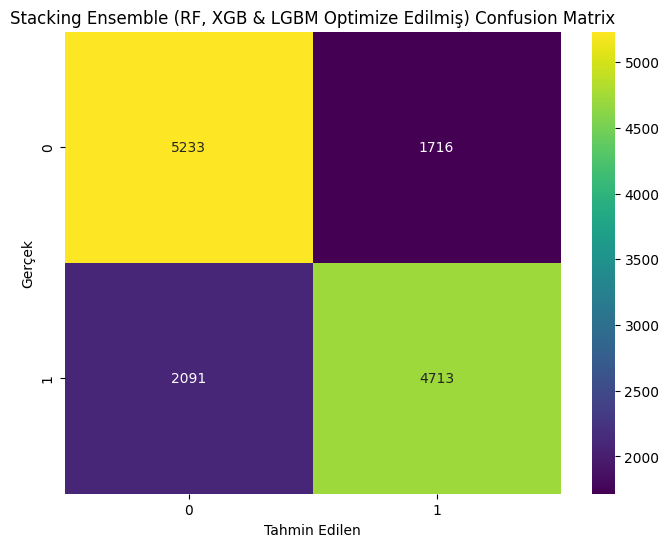

In [38]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optimize edilmiş modelleri kullan
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_
best_lgbm_model = random_search_lgbm.best_estimator_

# Temel modelleri tanımla (RF, XGB ve LGBM optimize edilmiş)
estimators = [
    ('rf', best_rf_model),
    ('xgb', best_xgb_model),
    ('lgbm', best_lgbm_model),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Meta-modeli tanımla
final_estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# Stacking Classifier'ı oluştur
stacking_clf_optimized_all_but_catb = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_optimized_all_but_catb.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_stacking_optimized_all_but_catb = stacking_clf_optimized_all_but_catb.predict(X_test)

# Performansı değerlendir
print("\nStacking Ensemble (RF, XGB & LGBM Optimize Edilmiş) Classification Report:")
print(classification_report(y_test, y_pred_stacking_optimized_all_but_catb))
print("Stacking Ensemble (RF, XGB & LGBM Optimize Edilmiş) Accuracy:", accuracy_score(y_test, y_pred_stacking_optimized_all_but_catb))

cm_stacking_optimized_all_but_catb = confusion_matrix(y_test, y_pred_stacking_optimized_all_but_catb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_optimized_all_but_catb, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Stacking Ensemble (RF, XGB & LGBM Optimize Edilmiş) Confusion Matrix')
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Final Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6949
           1       0.73      0.69      0.71      6804

    accuracy                           0.72     13753
   macro avg       0.72      0.72      0.72     13753
weighted avg       0.72      0.72      0.72     13753

Final Stacking Ensemble Accuracy: 0.722896822511452

En iyi C değeri (Final Meta-Model): {'C': 10}


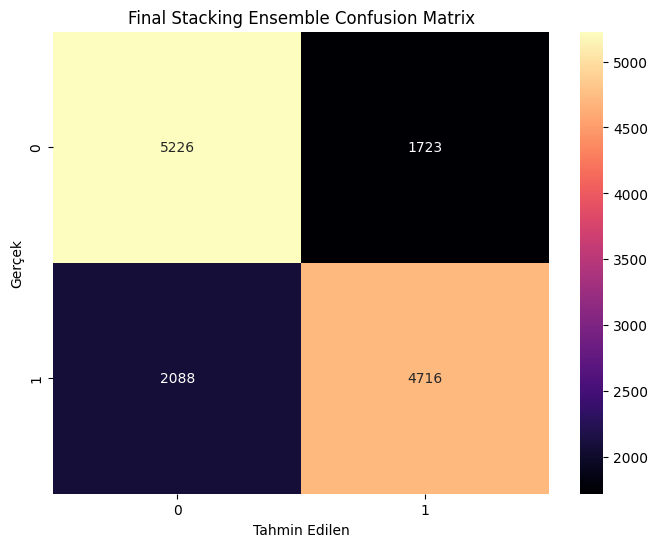

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optimize edilmiş temel modelleri kullan
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_
best_lgbm_model = random_search_lgbm.best_estimator_

# Temel modelleri tanımla (RF, XGB ve LGBM optimize edilmiş)
estimators = [
    ('rf', best_rf_model),
    ('xgb', best_xgb_model),
    ('lgbm', best_lgbm_model),
    ('catb', CatBoostClassifier(iterations=200, depth=7, learning_rate=0.05, random_seed=42, verbose=0))
]

# Meta-model için hiperparametre aralığı
param_grid_lr_final = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# GridSearchCV ile meta-model optimizasyonu
grid_search_lr_final = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42, max_iter=500),
                                    param_grid_lr_final,
                                    cv=5,
                                    scoring='accuracy',
                                    n_jobs=-1,
                                    verbose=2)

# Final Stacking Classifier'ı oluştur (meta-model optimizasyonu içinde)
stacking_clf_final = StackingClassifier(
    estimators=estimators,
    final_estimator=grid_search_lr_final,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Modeli eğit
stacking_clf_final.fit(X_train_resampled, y_train_resampled)

# En iyi meta-modeli al
best_final_estimator = stacking_clf_final.final_estimator_

# Tahmin yap
y_pred_stacking_final = stacking_clf_final.predict(X_test)

# Performansı değerlendir
print("\nFinal Stacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_final))
print("Final Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred_stacking_final))
print("\nEn iyi C değeri (Final Meta-Model):", best_final_estimator.best_params_)

cm_stacking_final = confusion_matrix(y_test, y_pred_stacking_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_final, annot=True, fmt='d', cmap='magma')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Final Stacking Ensemble Confusion Matrix')
plt.show()

In [40]:
import pickle

# En iyi modeli (örneğin final stacking modelini) kaydedin
best_model = stacking_clf_final

with open('cardio_risk_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model başarıyla kaydedildi: cardio_risk_model.pkl")

Model başarıyla kaydedildi: cardio_risk_model.pkl


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6632 - loss: 0.6167 - val_accuracy: 0.7300 - val_loss: 0.5898
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7241 - loss: 0.5654 - val_accuracy: 0.7354 - val_loss: 0.5619
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7339 - loss: 0.5530 - val_accuracy: 0.7348 - val_loss: 0.5447
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7349 - loss: 0.5432 - val_accuracy: 0.7366 - val_loss: 0.5451
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7329 - loss: 0.5454 - val_accuracy: 0.7384 - val_loss: 0.5374
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7339 - loss: 0.5411 - val_accuracy: 0.7386 - val_loss: 0.5436
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7364 - loss: 0.5400 - val_accuracy: 0.7396 - val_loss: 0.5349
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7307 - loss: 0.5458 - 

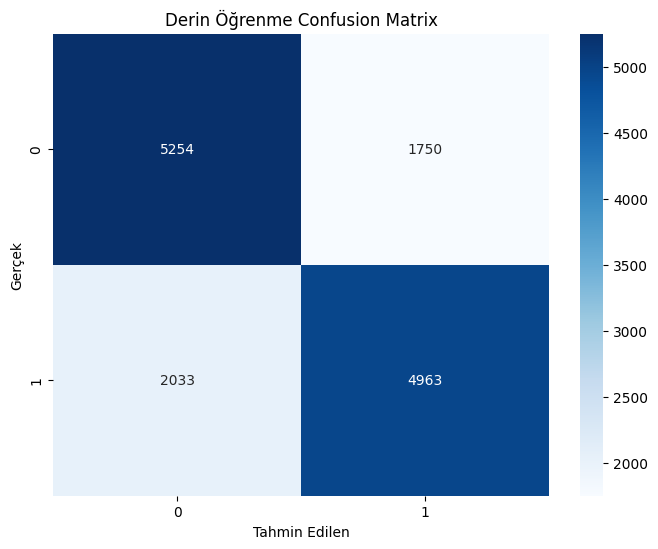

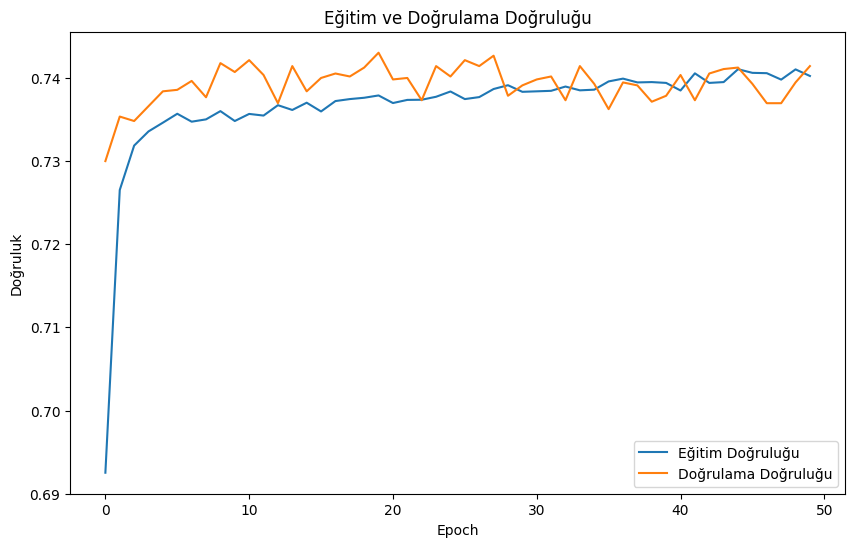

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veriyi Yükleme
data = pd.read_csv('cardio_train.csv', sep=';')

# Yaşı günlerden yıla çevirme (isteğe bağlı, modele etkisi olabilir)
data['age'] = (data['age'] / 365).round().astype(int)

# Gereksiz 'id' sütununu kaldırma
data = data.drop('id', axis=1)

# 2. Hedef Değişkeni ve Özellikleri Ayırma
X = data.drop('cardio', axis=1)
y = data['cardio']

# 3. Veriyi Eğitim ve Test Kümelerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Veriyi Ölçeklendirme (Derin Öğrenme İçin Önemli)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Derin Öğrenme Modelini Oluşturma (Basit bir MLP)
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # İkili sınıflandırma için sigmoid
])

# 6. Modeli Derleme
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. Modeli Eğitme
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 8. Modeli Değerlendirme
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Doğruluğu (Derin Öğrenme): {accuracy:.4f}")

# 9. Tahminler ve Sınıflandırma Raporu
y_pred_proba = model.predict(X_test_scaled)
y_pred_deep = (y_pred_proba > 0.5).astype(int)

print("\nDerin Öğrenme Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_deep))

# 10. Confusion Matrix
cm_deep = confusion_matrix(y_test, y_pred_deep)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Derin Öğrenme Confusion Matrix')
plt.show()

# İsteğe bağlı: Eğitim sürecini görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(history.h
istory['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.show()

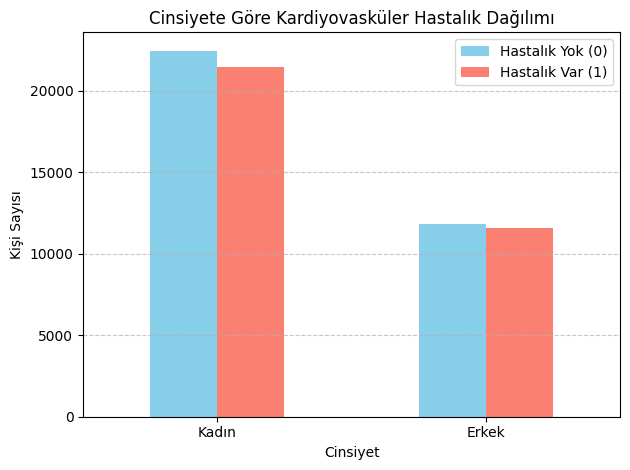

In [3]:
# Cinsiyete göre hastalık durumu dağılımını hesapla
gender_cardio_counts = df_cleaned.groupby(['gender', 'cardio']).size().unstack()

# Cinsiyet etiketlerini güncelle (1: Kadın, 2: Erkek)
gender_cardio_counts.index = gender_cardio_counts.index.map({1: 'Kadın', 2: 'Erkek'})

# Bar grafiği çiz
gender_cardio_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Cinsiyete Göre Kardiyovasküler Hastalık Dağılımı')
plt.xlabel('Cinsiyet')
plt.ylabel('Kişi Sayısı')
plt.legend(['Hastalık Yok (0)', 'Hastalık Var (1)'])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
